In [23]:
import numpy as np 
import pandas as pd

In [24]:
trainDf=pd.read_csv("Data/train.csv")
print(trainDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   15830 non-null  int64  
 1   value       15830 non-null  int64  
 2   is_anomaly  15830 non-null  bool   
 3   predicted   15830 non-null  float64
dtypes: bool(1), float64(1), int64(2)
memory usage: 386.6 KB
None


In [25]:
trainDf.head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [26]:
# !pip install matplotlib
import matplotlib.pyplot as plt


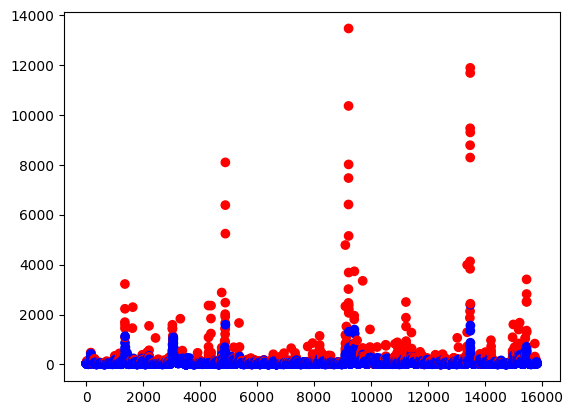

In [27]:
colors = np.where(trainDf["is_anomaly"]==False,'b','r')
# plt.scatter(trainDf['predicted'],trainDf['value'],c=colors)
plt.scatter(range(15830),trainDf['value'],c=colors)


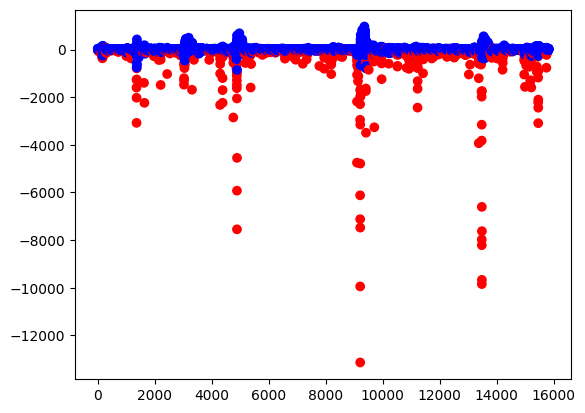

In [28]:
plt.scatter(range(15830),(trainDf['predicted']-trainDf['value']),c=colors)

In [29]:
trainDf.sort_values('timestamp').head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [30]:
trainDf.value_counts('value')

value
29      259
21      252
30      251
33      251
26      245
       ... 
1064      1
1068      1
1087      1
1091      1
2069      1
Name: count, Length: 631, dtype: int64

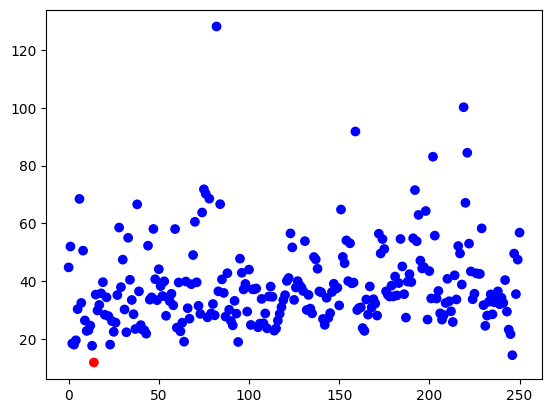

In [31]:
anomCol=[]
for i in range(15830):
    if trainDf['value'][i]==30:
        if trainDf['is_anomaly'][i]:
            anomCol.append('r')
        else:
            anomCol.append('b')
plt.scatter(range(251),trainDf[trainDf['value']==30]['predicted'],c=anomCol)

In [32]:
trainDf[trainDf['value']==30].head(85)

,timestamp,value,is_anomaly,predicted
31,1425017873,30,False,44.719856
36,1425019373,30,False,51.963814
85,1425034073,30,False,18.330496
89,1425035273,30,False,17.930708
91,1425035873,30,False,19.451230
...,...,...,...,...
4624,1426395773,30,False,32.028670
4708,1426420973,30,False,28.113440
5155,1426555073,30,False,128.268700
5214,1426572773,30,False,36.429480


In [33]:
trainDf.corr()

,timestamp,value,is_anomaly,predicted
timestamp,1.000000,0.032628,0.016457,0.030462
value,0.032628,1.000000,0.324859,0.445180
is_anomaly,0.016457,0.324859,1.000000,0.059719
predicted,0.030462,0.445180,0.059719,1.000000


In [34]:
points=[]
y=[]
for i in range(15830):
    curr=[trainDf['value'][i],abs(trainDf['predicted'][i]-trainDf['value'][i])]
    points.append(curr)
    if trainDf['is_anomaly'][i]==False:
        y.append(0)
    else:
        y.append(1)

# model bulding


In [35]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

print("Class weights:", class_weights)

Class weights: [ 0.52577388 10.19974227]


In [36]:
from sklearn import svm
# clf=svm.SVC(class_weight={0:4,1:95})
clf=svm.SVC(class_weight={0:0.52577388,1:10.19974227})
clf.fit(points,y)

SVC(class_weight={0: 0.52577388, 1: 10.19974227})

In [37]:
clf.predict([[20,100],[140,65]])

array([1, 1])

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, points, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.914


In [39]:
from sklearn.metrics import f1_score
print(f1_score(y,clf.predict(points)))

0.3776796973518285


# prediction on test dataset

In [42]:
testDf = pd.read_csv("Data/test.csv")
testDf.head()

,timestamp,value,predicted
0,1396332000,20.0,20.0
1,1396332300,20.0,20.0
2,1396332600,20.0,20.0
3,1396332900,20.0,20.0
4,1396333200,20.0,20.0


In [43]:
ans=[]
for i in range(3960):
    curr=[testDf['timestamp'][i]]
    is_anom=clf.predict([[testDf['value'][i],abs(testDf['predicted'][i]-testDf['value'][i])]])
    if is_anom==0:
        curr.append(False)
    else:
        curr.append(True)
    ans.append(curr)
ansDf=pd.DataFrame(ans,columns=['timestamp','is_anomaly'])

In [44]:
ansDf.head()
ansDf.value_counts('is_anomaly')

is_anomaly
False    3912
True       48
Name: count, dtype: int64

In [45]:
ansDf.to_csv("Data/answer.csv",index=False)